In [1]:
import numpy as np
import os
import pathlib
import random
import math
import sys
sys.path.append('/mnt/mbi/home/e0031794/Documents/DeePyMoD/src')

from deepymod.DeepMoD import DeepMoD
from deepymod.library_functions import library_1D
from deepymod.utilities import library_matrix_mat, print_PDE, tensorboard_to_dataframe
import pandas as pd

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import re

def get_total_time(data_folder):
    """
        data_folder (str): folder which stores metadata and data of a simulated trial
        return total_time (str): total simulation time, a string, in seconds
    """
    file_name  = ""
    #loop over data folder to find .txt file which contains Ttotal
    print("data_folder", data_folder)
    for file in os.listdir(data_folder):
        #find all matching files with .txt at the back
        if re.findall("^\w+_simulation_values.txt$", file):
            print("file", file)
            file_name = file
            break
    print("file_name", file_name)
    text_file = open(os.path.join(data_folder,file_name), "r")
    lines = text_file.readlines()
    target_line = ""
    #for loop searches for line with Ttotal
    for line in lines:
        if "Ttotal" in line:
            target_line = line
            break
    #target_line looks something like:'Total_sim_time(Ttotal):10\n'
    #so we need to get 10 without the \n
    total_time = target_line.split(":")[0]
    total_time = total_time.split("\n")[0] #\n removed, we have '10' now
    return total_time


def plot_util(data_dir,save_dir):

    """
        data_dir (str): directory which contains a list of folders which store simulated data for different trials

    """
    pathlib.Path(save_dir).mkdir(parents=True,exist_ok=True)
    for sub_data_dir in os.listdir(data_dir):
        final_save_dir = os.path.join(save_dir, sub_data_dir + "_plot")
        #create new folder to save plot for the ith trial
        pathlib.Path(final_save_dir).mkdir(parents=True,exist_ok=True)
        xx = "x_analy.npy"
        yy = "y_analy.npy"
        u = "u_numer.npy"
        #cd into curr folder, we want to Total simulation time for text file for each trial folder
        curr_trial_folder = os.path.join(data_dir,sub_data_dir)
        #print("curr_trial_folder", curr_trial_folder)
        total_time = get_total_time(curr_trial_folder)
        time_label = "t=" + total_time #time_label is the label for data generated by numerical method

        fig = plt.figure()
        xx_loaded = np.load(os.path.join(curr_trial_folder,xx))
        yy_loaded = np.load(os.path.join(curr_trial_folder,yy))
        u_loaded = np.load(os.path.join(curr_trial_folder,u))
        last_row = len(u_loaded) - 1 #last row is the final conc of bicoid when total simulation time is reached
        #plot data generated by analytical solution
        plt.plot(xx_loaded, yy_loaded, color="k", linewidth=4, label="Analytical")
        #plot data generated by analytical solution
        plt.plot(xx_loaded, u_loaded[last_row, :], '--', linewidth=2, label='Numerical')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.legend()
        #save plot as .jpg file with ith_trial as a prefix string
        file_name = os.path.join(final_save_dir, sub_data_dir+"_plot.png")
        print(final_save_dir)
        print(file_name)
        fig.savefig(file_name)


def plot_contour(
                x_npy, t_npy, u_npy, title, x_axis, y_axis,
                file_name="plot.png", subset=None):
    
    """
        x_npy (str): .npy file for spatial data generated by numerical method
        t_npy (str): .npy file for time data generated by numerical method
        u_npy (str): .npy file for bicoid concentration data generated by numerical method
        file_name (str): a file name of plot with .png extension at the end, default value is "plot.png"
        subset (int): a subset row values which a user wants to obtain
        
    """
    spatial_data_x = np.load(x_npy)
    time_data_y = np.load(t_npy)
    conc_data   = np.load(u_npy)
    if subset != None:
        plt.contourf(spatial_data_x[subset:-1,:], time_data_y[subset:-1,:], conc_data[subset:-1,:])
    else:
        plt.contourf(spatial_data_x, time_data_y, conc_data)
        
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.colorbar()
    plt.savefig(file_name)


In [5]:
def DD_numr(
            D, mu, init, source, 
            Lx, Ttotal, dtsave, dx, 
            dt, save_dir
            ):

    """
        D (float): diffusion coefficient
        mu (float): decay coefficient
        init (float): initial bicoid concentration
        source (int): position of initial source of bicoid, must be int, to access array values  
        Lx (int): total length of the x coordinate/total length of the egg
        Ttotal (int): total simulation time in seconds
        dtsave (int): time interval for saving data in seconds
        dx (float): change in bicoid concentration along the x coordinate
        dt (float): change in bicoid concentration along the t coordinate
        save_dir (str): folder to save data to

        returns:
            x (np arr): data of positional coordinates
            s (np arr): data of time coordinates
            u (np arr): data of bicoid concentrations

    """

    if dt > dx**2/D:
        #to ensure dt is small enough so that we could capture concentration of bicoid as smooth as possible
        #instead of as snapshots
        print('dt exceeds dtlim = {dx**2/D}')
        return 
    #create path
    pathlib.Path(save_dir).mkdir(parents=True,exist_ok=True)
    """
        nx : total number of spatial intervals
        nt : total number of time intervals
        ns : total number of save intervals

    """
    nx = round(Lx/dx)+1         #get number of spatial intervals        
    nt = round(Ttotal/dt)+1     #get number of time intervals to iterate through   
    ns = round(Ttotal/dtsave)+1 #number of intervals to save data regularly
    dsave = round(dtsave/dt)    #number of frames step to save 
    
    xx = np.arange(0, nx)*dx    #simulation position 
    ss = np.arange(0, ns)*dtsave  #time position 
    x,s = np.meshgrid(xx, ss)     #x is the x coord of 2d mat, s is the y coord of 2d mat
    
    u = np.zeros(x.shape) #initialise simulation matrix, where i,j entry is the concentration at position x,
                            #column == j position, row = ith time
    u2 = np.zeros(nx+2) #include boundary condition, left and right, conc of morphogens in 1D
    u2[source+1] = init #set initiation concentration not transpassing into boundaries
    u[0,:] = u2[1:nx+1] #set 1st row, row == 0th time with initial concentration condition 
    
    for ii in range(1,nt):
        u1 = u2

        u2[1:nx+1] \
        = (D*dt/(dx**2))*(u1[2:nx+2]+u1[0:nx]-2*u1[1:nx+1]) \
           - mu*dt*u1[1:nx+1] + u1[1:nx+1] #update non-boundary

        u2[0] = u2[1] #update boundary
        u2[-1] = u2[-2] #update boundary 
        u2 = np.clip(u2, a_min = 0, a_max = None) #remove negative values, set all negatives to 0 
    
        if ii%dsave == 0:
            jj = round(ii/dsave)
            u[jj,:] = u2[1:nx+1]
            
    np.save(os.path.join(save_dir,"x_numer"), x)
    np.save(os.path.join(save_dir,"s_numer"), s)
    np.save(os.path.join(save_dir,"u_numer"),u)
    
    return x, s, u

def DD_anly(
            x, t, source, D, 
            m, j, save_dir):

    """
        x (np arr): positional data
        t (int): total simulation time in seconds
        source (int): x position of source
        D (int):    diffusion coeff
        m (int): decay coeff
        j (int): initial bicoid concentration

        returns:
            c (np arr): bicoid concentration after simulation?
    """
    #create path
    pathlib.Path(save_dir).mkdir(parents=True,exist_ok=True)
    c = j / np.sqrt(4 * np.pi * D * t) * np.exp(-(x-source)**2 / (4 * D * t) - m*t)
    np.save(os.path.join(save_dir,"x_analy"),x)
    np.save(os.path.join(save_dir,"y_analy"),c)
    return c

def randomised_trials(num_trials, save_dir):
    
    """
        num_trials (int): number of trials to initialise parameters of PDEs
        save_dir (string): parent node of the ith file folder which will store simulated for the ith number of trial.

    """
    #dtsave = 0.001 #set this constants
    for i in range(num_trials):
        #let ith dir to store data be save_dir + str(i+1
        ith_save_dir = save_dir + "/" + str(i+1) + "_trial"
        pathlib.Path(ith_save_dir).mkdir(parents=True,exist_ok=True)
        #write parameter/simulation values into ith folder:
        file_name = ith_save_dir + "/" + str(i+1) + "_trial_simulation_values.txt"
        f = open(file_name, "w+")

        #first, let's randomised parameters shared by DD_numr and DD_anly
        Diff_coeff = 3 #[a,b], Diff_coeff = D
        #decay_coeff = random.uniform(mu_lower, mu_upper) #[a,b], decay_coeff = mu
        decay_coeff = 0 
        #init_conc = init
        init_conc = 88
        #Total_sim_time = Ttotal; means total simulation time #time is in seconds 
        Total_sim_time = 10        
        #randomised dx, Lx, source, dt
        dx = 1.01
        #Lx = random.randint(30,40)
        Lx = 30
        dt = 0.001
        source = 15
        #create xx for DD_anly
        xx = np.arange(0, round(Lx/dx)+1)*dx
        

        #write and save parameters
        f.write("Diff_coeff(D):" + str(Diff_coeff) + "\n")
        f.write("decay_coeff(mu):" + str(decay_coeff) + "\n")
        f.write("init_conc(init):" + str(init_conc) + "\n")
        f.write("Total_sim_time(Ttotal):" + str(Total_sim_time) + "\n")
        f.write("dx:" + str(dx) + "\n")
        f.write("Lx:" + str(Lx) + "\n")
        f.write("dt:" + str(dt) + "\n")
        f.write("source:" + str(source) + "\n")
        f.write("xx:" + np.array_str(xx) + "\n")

        f.close()

        DD_numr(D=Diff_coeff, mu=decay_coeff, init=init_conc, 
                source=source, Lx=Lx, Ttotal=Total_sim_time, 
                dtsave= dt, dx=dx, dt=dt, 
                save_dir=ith_save_dir
                ) #set dtsave as dt

        #attempt to fix bug
        DD_anly(x=xx, t=Total_sim_time, source=xx[source], D=Diff_coeff, 
                m=decay_coeff, j=init_conc,
                save_dir=ith_save_dir)

In [4]:
def sample_data(
            x_npy, t_npy, u_npy,
            sampling_ratio, subset, dir
        ):
    
    """
        x_npy (str): .npy file for spatial data generated by numerical method
        t_npy (str): .npy file for time data generated by numerical method
        u_npy (str): .npy file for bicoid concentration data generated by numerical method
        sampling_ratio (float): % of samples to be taken from space_time_data
        subset (int): slice some number of rows for x_npy, t_npy, u_npy
        dir(str): dir to save np files generated with this function
        
        returns: 
        space_time_data (np array): original data without sampling
        conc (np array): original conc data without sampling
        space_time_train (np array): sampled training data
        conc_train (np array): sampled ground truth data
        
    """
    pathlib.Path(dir).mkdir(parents=True,exist_ok=True)
    space = np.load(x_npy)[subset:-1,:].flatten() #vectorise matrix
    time = np.load(t_npy)[subset:-1,:].flatten()  #vectorise matrix
    conc = np.load(u_npy)[subset:-1,:]
    conc = conc.reshape(conc.size,1)#vectorise matrix
    space_time_data = np.transpose((space,time))#combine space and time vectors into a matrix of 2 columns
    
    #sampling from data aka train-test-split, but without the test
    num_samples = math.floor(space_time_data.shape[0] * sampling_ratio)
    indices = np.random.choice(space_time_data.shape[0], num_samples, replace=False)
    space_time_train = space_time_data[indices]
    conc_train = conc[indices]
    np.save('space_time_data_full_'+str(subset), space_time_data)
    np.save('space_time_data_sampled_'+str(subset),space_time_train)
    np.save('bicoid_full_'+str(subset), conc)
    np.save('bicoid_sampled_'+str(subset), conc_train)
    
    return space_time_data, conc, space_time_train, conc_train


In [6]:
randomised_trials(num_trials=1,save_dir="/mnt/mbi/home/e0031794/Documents/FYP/FYP_results_11_9_2019/diffusion_plots")
os.chdir("/mnt/mbi/home/e0031794/Documents/FYP/FYP_results_11_9_2019/diffusion_plots")

data_folder /mnt/mbi/home/e0031794/Documents/FYP/FYP_results_11_9_2019/diffusion_plots/1_trial
file 1_trial_simulation_values.txt
file_name 1_trial_simulation_values.txt
/mnt/mbi/home/e0031794/Documents/FYP/FYP_results_11_9_2019/diffusion_plots/1_trial_plot
/mnt/mbi/home/e0031794/Documents/FYP/FYP_results_11_9_2019/diffusion_plots/1_trial_plot/1_trial_plot.png


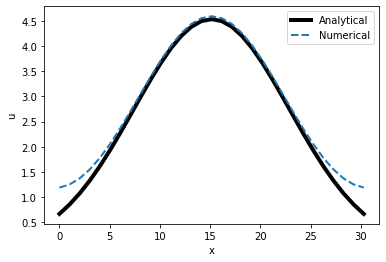

In [7]:
plot_util(data_dir="/mnt/mbi/home/e0031794/Documents/FYP/FYP_results_11_9_2019/diffusion_plots",
          save_dir="/mnt/mbi/home/e0031794/Documents/FYP/FYP_results_11_9_2019/diffusion_plots")

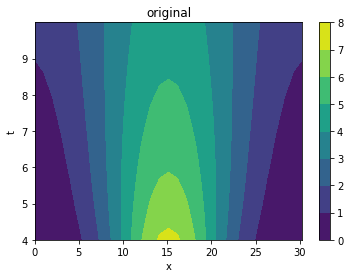

In [8]:
plot_contour("x_numer.npy", "s_numer.npy", "u_numer.npy", "original" ,"x", "t","4000_trial_ground_truth.png", subset=4000)